In [2]:
using Pkg
Pkg.add(url="https://github.com/jwmi/BayesianMixtures.jl")

   Updating git-repo `https://github.com/jwmi/BayesianMixtures.jl`


   Updating registry at `C:\Users\M_AMIRKH\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\M_AMIRKH\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\M_AMIRKH\.julia\environments\v1.5\Manifest.toml`


In [152]:
# Reversible jump MCMC for axis-aligned multivariate normal mixtures, using a conjugate prior.
module MVNaaRJ

include("BayesianMixtures.jl\\src\\RandomNumbers.jl")
using .RandomNumbers

using Statistics
using SpecialFunctions
lgamma_(x) = logabsgamma(x)[1]
lbeta_(a,b) = (logabsbeta(a,b))[1]

const Data = Array{Float64,1}
mutable struct Theta
    mu::Array{Float64,1}     # means
    lambda::Array{Float64,1} # precisions
end

# Include generic code
include("BayesianMixtures.jl\\src\\generic.jl")

logsumexp(a,b) = (m = max(a,b); m == -Inf ? -Inf : log(exp(a-m) + exp(b-m)) + m)

lognormpdf(x,m,v) = -0.5*(x-m)*(x-m)/v - 0.5*log(2*pi*v)
logmvnpdf(x,m,v,c) = (l=0.0; for j=1:length(x); l += lognormpdf(x[j],m[c,j],v[c,j]); end; l)

mutable struct Hyperparameters
    log_pk_vec::Array{Float64,1} # log of prior on the number of components
    gamma::Float64 # Dirichlet parameter
    d::Int64    # dimension
    # m[c,i]|v[c,i] ~ N(m,v[c,i]/r)
    m::Float64  # prior mean of m's
    r::Float64  # factor for prior precision of m's
    # v[c,i] ~ InvGamma(a,b)
    a::Float64  # prior shape of v's
    b::Float64  # prior scale of v's
end

function construct_hyperparameters(options)
    x = options.x
    n = length(x)
    d = length(x[1])
    mu = mean(x)
    v = mean([xi.*xi for xi in x]) - mu.*mu  # sample variance
    @assert(all(abs.(mu) .< 1e-10) && all(abs.(v .- 1.0) .< 1e-10), "Data must be normalized to zero mean, unit variance.")
    m = 0.0
    r = 1.0
    a = 1.0
    b = 1.0
    gamma = options.gamma
    lpk = eval(Meta.parse(options.log_pk))
    log_pk_fn(k) = Base.invokelatest(lpk,k)
    log_pk_vec = Float64[log_pk_fn(k) for k = 1:options.k_max]
    return Hyperparameters(log_pk_vec,gamma,d,m,r,a,b)
end


mutable struct List
    first::Int64
    next::Array{Int64,1}
    List(maxlen) = (l=new(); l.first=0; l.next=zeros(Int64,maxlen); return l)
end
insert!(l::List,i) = (l.next[i] = l.first; l.first = i) # Note: i must not already be in the list.
pop!(l::List) = (i = l.first; @assert(i!=0,"list capacity exceeded"); l.first = l.next[i]; i)
function remove!(l::List,i) # Note: i must already be in the list.
    if i==l.first
        l.first = l.next[i]
    else
        j = l.first
        while j != 0
            if i==l.next[j]; l.next[j] = l.next[i]; break; end
            j = l.next[j]
        end
    end
end
#pr(l::List) = (i=l.first; while i!=0; print(i," "); i=l.next[i]; end; println())

mutable struct IndexList
    first::Array{Int64,1}
    next::Array{Int64,1}
    IndexList(kmax,n) = (l=new(); l.first=zeros(Int64,kmax); l.next=zeros(Int64,n); return l)
end
insert!(l::IndexList,c,i) = (l.next[i] = l.first[c]; l.first[c] = i)
clear!(l::IndexList,c) = (l.first[c] = 0)


# sample from categorical distn p on list
function randp(p,list::List)
    u = rand()
    i = list.first
    s = p[i]
    while u > s
        i = list.next[i]
        s += p[i]
    end
    return i
end

# sample from uniform distn on list of k items
function randunif(k,list::List)
    u = rand()*k
    i = list.first
    s = 1.0
    while u > s
        i = list.next[i]
        s += 1.0
    end
    return i
end

# update assignments z
function update_assignments!(x,z,w,m,v,clist,log_p,p)
    for i = 1:length(x)
        c,log_s = clist.first,-Inf
        while c != 0
            log_p[c] = log(w[c]) + logmvnpdf(x[i],m,v,c)
            log_s = logsumexp(log_s,log_p[c])
            c = clist.next[c]
        end
        c = clist.first
        while c != 0
            p[c] = exp(log_p[c] - log_s)
            c = clist.next[c]
        end
        z[i] = randp(p,clist)
    end
end

# recompute t,s,sx,ssx,ilist
function recompute_statistics!(x,z,s,sx,ssx,ilist,clist,H)
    c = clist.first
    while c != 0
        s[c] = 0
        clear!(ilist,c)
        for j = 1:H.d; sx[c,j] = 0.0; ssx[c,j] = 0.0; end
        c = clist.next[c]
    end
    t = 0
    for i = 1:length(x)
        c = z[i]
        if s[c]==0; t+=1; end
        insert!(ilist,c,i)
        s[c] += 1
        for j = 1:H.d
            sx[c,j] += x[i][j]
            ssx[c,j] += x[i][j]*x[i][j]
        end
    end
    return t
end

# update weights, means, and variances
function update_parameters!(w,m,v,s,sx,ssx,clist,H)
    # update weights (unnormalized for now)
    c = clist.first
    w_sum = 0.0
    while c != 0
        w[c] = RandomNumbers.gamma(H.gamma+s[c],1)
        w_sum += w[c]
        c = clist.next[c]
    end
    
    c = clist.first
    while c != 0
        A = H.a + 0.5*(s[c]+1)
        for j = 1:H.d
            # update mean
            L = (H.r + s[c])/v[c,j]
            M = (H.r*H.m + sx[c,j]) / (H.r + s[c])
            m[c,j] = randn()/sqrt(L) + M
            
            # update variance
            B = H.b + 0.5*(ssx[c,j] - 2*m[c,j]*sx[c,j] + s[c]*m[c,j]*m[c,j]) + 0.5*H.r*(m[c,j]-H.m)*(m[c,j]-H.m)
            # if (A<=0 || B<=0); println(A," ",B)
                # println(H.b)
                # println(0.5*(ssx[c,j] - 2*m[c,j]*sx[c,j] + s[c]*m[c,j]*m[c,j]))
                # println(0.5*H.r*(m[c,j]-H.m)*(m[c,j]-H.m))
            # end
            v[c,j] = RandomNumbers.inverse_gamma(A,B)
        end
        
        # normalize weights
        w[c] = w[c]/w_sum
        c = clist.next[c]
    end
end

function log_prior_ratio(k,w,m,v,cm,c1,c2,s1,s2,H)
    ssm,slv,siv = 0.0,0.0,0.0
    for j = 1:H.d
        ssm += (m[c1,j]-H.m)^2/v[c1,j] + (m[c2,j]-H.m)^2/v[c2,j] - (m[cm,j]-H.m)^2/v[cm,j]
        slv += log(v[c1,j]*v[c2,j]/v[cm,j])
        siv += 1/v[c1,j] + 1/v[c2,j] - 1/v[cm,j]
    end
    log_rprior = (H.log_pk_vec[k+1] - H.log_pk_vec[k] # prior on k
               + (H.gamma-1)*log(w[c1]*w[c2]/w[cm]) - lbeta_(H.gamma,k*H.gamma) # prior on w
               + s1*log(w[c1]) + s2*log(w[c2]) - (s1+s2)*log(w[cm]) # prior on z
               + 0.5*H.d*log(H.r/(2*pi)) - 0.5*H.r*ssm - 0.5*slv # prior on m
               + H.d*H.a*log(H.b) - H.d*lgamma_(H.a) + (-H.a-1)*slv - H.b*siv) # prior on v
    return log_rprior
end

function log_Jacobian(w,v,u1,u2,cm,H)
    log_J = log(w[cm]) - 1.5*H.d*log(u1*(1-u1))
    for j = 1:H.d; log_J += log(1-u2[j]*u2[j]) + 1.5*log(v[cm,j]); end
    return log_J
end

# propose split-merge move
function split_merge!(k,t,x,z,w,m,v,s,sx,ssx,clist,cfree,ilist, zs,u2,u3,H)
    if ((k==1) || (rand()<0.5)) # propose split
        # choose component indices
        cm = randunif(k,clist)
        c1 = pop!(cfree)
        c2 = pop!(cfree)
        # sample u's
        log_pu = 0.0
        u1 = RandomNumbers.beta(2,2); log_pu += log(6*u1*(1-u1))
        for j = 1:H.d
            u2[j] = RandomNumbers.beta(2,2); log_pu += log(6*u2[j]*(1-u2[j]))
            u3[j] = rand(); # log_pu += 0.0
        end
        # split w, m, and v
        w[c1],w[c2] = w[cm]*u1, w[cm]*(1-u1)
        for j = 1:H.d
            m[c1,j] = m[cm,j] - u2[j]*sqrt(v[cm,j]*w[c2]/w[c1])
            m[c2,j] = m[cm,j] + u2[j]*sqrt(v[cm,j]*w[c1]/w[c2])
            v[c1,j] = u3[j]*(1-u2[j]*u2[j])*v[cm,j]*w[cm]/w[c1]
            v[c2,j] = (1-u3[j])*(1-u2[j]*u2[j])*v[cm,j]*w[cm]/w[c2]
        end
        # split z and simultaneously compute the log likelihood ratio
        log_pzs = 0.0
        log_rlik = 0.0
        s1,s2 = 0,0
        i = ilist.first[cm]
        while i != 0
            l1,l2,lm = logmvnpdf(x[i],m,v,c1),logmvnpdf(x[i],m,v,c2),logmvnpdf(x[i],m,v,cm)
            p1 = 1/(1 + exp(l2-l1)*w[c2]/w[c1])
            if rand() < p1
                zs[i] = c1
                s1 += 1
                log_pzs += log(p1)
                log_rlik += l1 - lm
            else
                zs[i] = c2
                s2 += 1
                log_pzs += log(1-p1)
                log_rlik += l2 - lm
            end
            i = ilist.next[i]
        end
        # log of the ratio of move probabilities (choice of split or merge)
        log_rmove = (k==1 ? log(0.5) : 0.0)
        
        # log prior ratio
        log_rprior = log_prior_ratio(k,w,m,v,cm,c1,c2,s1,s2,H)

        # log of the Jacobian
        log_J = log_Jacobian(w,v,u1,u2,cm,H)

        # acceptance probability
        p_accept = min(1,exp(log_rlik + log_rprior + log_rmove - log_pu - log_pzs + log_J))

        # accept or reject
        if rand() < p_accept
            # k,t,z,s,w,m,v,sx,ssx,clist,cfree,ilist
            k += 1
            t += Int((s1>0) && (s2>0))
            s[c1],s[c2] = s1,s2
            for j=1:H.d; sx[c1,j]=0.0; sx[c2,j]=0.0; ssx[c1,j]=0.0; ssx[c2,j]=0.0; end
            clear!(ilist,c1); clear!(ilist,c2)
            i = ilist.first[cm]
            while i != 0
                c = zs[i]
                z[i] = c
                for j = 1:H.d
                    sx[c,j] += x[i][j]
                    ssx[c,j] += x[i][j]*x[i][j]
                end
                next = ilist.next[i]
                insert!(ilist,c,i)
                i = next
            end
            insert!(clist,c1); insert!(clist,c2)
            remove!(clist,cm); insert!(cfree,cm)
        else
            insert!(cfree,c1); insert!(cfree,c2)
        end
    else # propose merge
        # choose component indices
        c1 = randunif(k,clist); remove!(clist,c1)
        c2 = randunif(k-1,clist); insert!(clist,c1)
        cm = pop!(cfree)
        # merge w, m, and v
        w[cm] = w[c1] + w[c2]
        for j = 1:H.d
            m[cm,j] = (w[c1]*m[c1,j] + w[c2]*m[c2,j])/w[cm]
            v[cm,j] = (w[c1]*(m[c1,j]^2 + v[c1,j]) + w[c2]*(m[c2,j]^2 + v[c2,j]))/w[cm] - m[cm,j]^2
        end
        # compute u's
        log_pu = 0.0
        u1 = w[c1]/w[cm]; log_pu += log(6*u1*(1-u1))
        for j = 1:H.d
            u2[j] = (m[cm,j] - m[c1,j])/sqrt(v[cm,j]*w[c2]/w[c1]); log_pu += log(6*u2[j]*(1-u2[j])*(0<=u2[j]<=1))
            u3[j] = (v[c1,j]*w[c1])/(v[cm,j]*w[cm]*(1-u2[j]*u2[j])); log_pu += (0<=u3[j]<=1 ? 0.0 : -Inf)
        end
        # merge z and compute the log likelihood ratio
        log_pzs = 0.0
        log_rlik = 0.0
        i = ilist.first[c1]
        while i != 0
            l1,l2,lm = logmvnpdf(x[i],m,v,c1),logmvnpdf(x[i],m,v,c2),logmvnpdf(x[i],m,v,cm)
            p1 = 1/(1 + exp(l2-l1)*w[c2]/w[c1])
            log_pzs += log(p1)
            log_rlik += lm - l1
            i = ilist.next[i]
        end
        i = ilist.first[c2]
        while i != 0
            l1,l2,lm = logmvnpdf(x[i],m,v,c1),logmvnpdf(x[i],m,v,c2),logmvnpdf(x[i],m,v,cm)
            p1 = 1/(1 + exp(l2-l1)*w[c2]/w[c1])
            log_pzs += log(1-p1)
            log_rlik += lm - l2
            i = ilist.next[i]
        end
        # log of the ratio of move probabilities (choice of split or merge)
        log_rmove = 0.0

        # log prior ratio
        log_rprior = -log_prior_ratio(k-1,w,m,v,cm,c1,c2,s[c1],s[c2],H)

        # log of the Jacobian
        log_J = -log_Jacobian(w,v,u1,u2,cm,H)
        
        # acceptance probability
        p_accept = min(1,exp(log_rlik + log_rprior + log_rmove + log_pu + log_pzs + log_J))

        # accept or reject
        if rand() < p_accept
            # k,t,z,w,m,v,s,sx,ssx,clist,cfree,ilist
            k -= 1
            t -= Int((s[c1]>0) && (s[c2]>0))
            s[cm] = s[c1] + s[c2]
            for j = 1:H.d
                sx[cm,j] = sx[c1,j] + sx[c2,j]
                ssx[cm,j] = ssx[c1,j] + ssx[c2,j]
            end
            clear!(ilist,cm)
            for i in [ilist.first[c1],ilist.first[c2]]
                while i != 0
                    z[i] = cm
                    next = ilist.next[i]
                    insert!(ilist,cm,i)
                    i = next
                end
            end
            insert!(clist,cm) 
            remove!(clist,c1); remove!(clist,c2)
            insert!(cfree,c1); insert!(cfree,c2)
        else
            insert!(cfree,cm)
        end
    end
    return k,t
end

function birth_death!(k,t,n,w,m,v,s,sx,ssx,clist,cfree,ilist,H)
    k0 = k-t # number of empty components
    if rand() < 0.5 # propose birth of an empty component
        c = pop!(cfree)
        w[c] = RandomNumbers.beta(1,k)
        for j = 1:H.d
            v[c,j] = RandomNumbers.inverse_gamma(H.a,H.b)
            m[c,j] = randn()*sqrt(v[c,j]/H.r) + H.m
        end
        log_A = (H.log_pk_vec[k+1] - H.log_pk_vec[k]
              + (n+k*(H.gamma-1))*log(1-w[c]) + (H.gamma-1)*log(w[c])
              + lbeta_(1,k) - lbeta_(H.gamma,k*H.gamma) + log(k+1) - log(k0+1))
        p_accept = min(1,exp(log_A))
        
        # accept or reject
        if rand() < p_accept
            # k,t,z,w,m,v,s,sx,ssx,clist,cfree,ilist
            k += 1
            s[c] = 0
            for j = 1:H.d; sx[c,j] = 0.0; ssx[c,j] = 0.0; end
            insert!(clist,c)
            clear!(ilist,c)
        else
            insert!(cfree,c)
        end
    elseif (k0 > 0) # propose death of an empty component
        # randomly choose an empty component
        u = rand()*k0
        c = clist.first
        S = Int(s[c]==0)
        while u > S
            c = clist.next[c]
            S += Int(s[c]==0)
        end
        # compute acceptance probability
        log_A = (H.log_pk_vec[k] - H.log_pk_vec[k-1]
              + (n+(k-1)*(H.gamma-1))*log(1-w[c]) + (H.gamma-1)*log(w[c])
              + lbeta_(1,k-1) - lbeta_(H.gamma,(k-1)*H.gamma) + log(k) - log(k0))
        p_accept = min(1,exp(-log_A))
        
        # accept or reject
        if rand() < p_accept
            # k,t,z,w,m,v,s,sx,ssx,clist,cfree,ilist
            k -= 1
            remove!(clist,c)
            insert!(cfree,c)
        end
    end
    return k,t
end


function sampler(options,n_total,n_keep)
    H = construct_hyperparameters(options)
    x,n = options.x,options.n
    kmax = min(n,options.k_max)
    @assert(n==length(x))
    d = H.d # dimension
    
    # State
    # k,t,z,s,w,m,v,sx,ssx,cfirst,cnext,cfree,ilist
    k = 1 # number of components
    t = 1 # number of clusters (non-empty components)
    z = zeros(Int64,n) # z[i] = component assignment of datapoint i
    w = zeros(kmax) # w[c] = mixture weight of component c
    m = zeros(kmax,d) # m[c,:] = means of component c
    v = zeros(kmax,d) # v[c,:] = variances of component c
    s = zeros(Int64,kmax) # s[c] = # of points assigned to component c
    sx = zeros(kmax,d) # sx[c,:] = sum of the x's in component c
    ssx = zeros(kmax,d) # ssx[c,:] = sum of the squares of the x's in component c
    clist = List(kmax) # component list
    cfree = List(kmax) # list of unused components
    ilist = IndexList(kmax,n) # lists of indices assigned to each component
    
    # initialize with a single component
    z[:] .= 1
    s[1] = n
    m[1,:] = mean(x) # initialize to the sample mean
    v[1,:] = mean([(xi-vec(m[1,:])).^2 for xi in x]) # initialize to the sample variance
    sx[1,:] = sum(x)
    ssx[1,:] = sum([xi.^2 for xi in x])
    insert!(clist,1)
    for c=kmax:-1:2; insert!(cfree,c); end
    for i = 1:n; insert!(ilist,1,i); end
    
    # temporary variables
    p = zeros(kmax) # temporary variable for randp
    log_p = zeros(kmax) # temporary variable
    zs = zeros(Int64,n) # temporary assignments for split-merge
    u2,u3 = zeros(d),zeros(d) # temporary variables for split-merge

    # iterations to record
    keepers = round.(Int,range(round(Int,n_total/n_keep),stop=n_total,length=n_keep))
    keep_index = 0
    
    # records
    #k_r = zeros(Int64,n_total)
    t_r = zeros(Int8,n_total); @assert(kmax < 2^7)
    N_r = zeros(Int16,kmax+3,n_total); @assert(n < 2^15)
    z_r = zeros(Int8,n,n_keep); @assert(kmax < 2^7)
    theta_r = Array{Theta}(undef,kmax+3,n_keep)
    
    for iteration = 1:n_total
        # update weights, means, and variances
        update_parameters!(w,m,v,s,sx,ssx,clist,H)

        # update assignments z
        update_assignments!(x,z,w,m,v,clist,log_p,p)
        # recompute t,s,sx,ssx,ilist based on the new z
        t = recompute_statistics!(x,z,s,sx,ssx,ilist,clist,H)
        
        # split/merge
        k,t = split_merge!(k,t,x,z,w,m,v,s,sx,ssx,clist,cfree,ilist, zs,u2,u3,H)

        # birth/death
        k,t = birth_death!(k,t,n,w,m,v,s,sx,ssx,clist,cfree,ilist,H)

        # record-keeping
        #k_r[iteration] = k
        t_r[iteration] = t
        for i = 1:n
            N_r[z[i],iteration] += 1
        end
        if iteration==keepers[keep_index+1]
            keep_index += 1
            for i = 1:n; z_r[i,keep_index] = z[i]; end
            c = clist.first
            while c != 0
                theta_r[c,keep_index] = Theta(m[c,:][:], 1.0./v[c,:][:])
                c = clist.next[c]
            end
        end
    end
#     println(z)
    return t_r,N_r,z_r,theta_r,keepers
end

end # module

Main.MVNaaRJ

In [5]:
import Pkg; Pkg.add("SpecialFunctions")

  Resolving package versions...
Updating `C:\Users\M_AMIRKH\.julia\environments\v1.5\Project.toml`
  [276daf66] + SpecialFunctions v0.10.3
No Changes to `C:\Users\M_AMIRKH\.julia\environments\v1.5\Manifest.toml`


In [11]:
using BayesianMixtures

# Simulate some data
x = randn(500)

# Specify model, data, and MCMC options
n_total = 1000  # total number of MCMC sweeps to run
options = BayesianMixtures.options("Normal","MFM",x,n_total)  # MFM with univariate Normal components

# Run MCMC sampler
result = BayesianMixtures.run_sampler(options)

# Get the posterior on k (number of components) 
k_posterior = BayesianMixtures.k_posterior(result)

Normal MFM
n = 500, n_total = 1000, n_keep = 1000
Running... complete.
Elapsed time = 0.302107899 seconds
Time per step ~ 6.04215798e-7 seconds


40-element Array{Float64,1}:
 0.8668686296730411
 0.10313796916453213
 0.027188865042231985
 0.0027155535284985066
 8.670019110446669e-5
 2.2267136140717046e-6
 5.431927592899874e-8
 1.333164771847638e-9
 3.3726585351248485e-11
 8.891278075109248e-13
 2.4544537747395113e-14
 7.10752590584025e-16
 2.159416898520265e-17
 ⋮
 2.8710467334595216e-39
 1.6338508253515318e-40
 9.553204127501389e-42
 5.7347141204381996e-43
 3.531660018363375e-44
 2.229689821999464e-45
 1.4421724443835495e-46
 9.55035654887879e-48
 6.47123184864664e-49
 4.484011232626246e-50
 3.175538979421847e-51
 2.297251195271824e-52

In [ ]:
# Compare Jain-Neal sampler to Reversible Jump on simulated data of increasing dimension.
module SimCompareJNtoRJ

using Statistics
using Random
using BayesianMixtures
B = BayesianMixtures

# Settings
ds = [4,8,12]  # increasing dimensions
reset_random = true  # reset the random number generator before each run
save_figures = true  # save the figures to file
n_total = 1000000  # number of MCMC sweeps to run each algorithm

fignum = 0
for (i_d,d) in enumerate(ds)
    B.open_figure(9+i_d)
    for (label,mode,color) in [("Collapsed Jain-Neal","MVNaaC","g"),
                               ("Uncollapsed Jain-Neal","MVNaaN","r"),
                               ("RJMCMC","MVNaaRJ","b")]
    
        if reset_random; Random.seed!(0); end

        # Generate data
        n = 100
        xs = [randn(d) for i = 1:n]
        zs = [Int(ceil(rand()*3)) for i = 1:n]
        shift = (3/sqrt(d))*[-1,0,1]
        x = convert(Array{Array{Float64,1},1},[xs[i].+shift[zs[i]] for i = 1:n])
        mu = mean(x)  # sample mean
        v = mean([xi.*xi for xi in x]) - mu.*mu  # sample variance
        x = [((xi-mu)./sqrt.(v))::Array{Float64,1} for xi in x] # normalized to zero mean, unit variance

        # Run sampler
        println(label)
        options = B.options(mode,"MFM",x,n_total; n_keep=1000,t_max=20)
        result = B.run_sampler(options)

        # Traceplot of t
        global fignum
        B.open_figure(fignum+=1)
        t_show = 20  # number of seconds to show
        B.traceplot_timewise(result,t_show)
        B.PyPlot.title("$label, d = $d")
        if save_figures; B.PyPlot.savefig("simCompareJNtoRJ-traceplot-$mode-d=$d.png",dpi=200); end

        # Plot autocorrelation
        B.open_figure(9+i_d; clear_figure=false)
        t_show = 0.025*d  # number of seconds to show
        B.plot_autocorrelation(result,t_show; color=color,label=label)
        B.PyPlot.title("Autocorrelation, d = $d")
    end
    if i_d==1; B.PyPlot.legend(loc="upper right",fontsize=12); end
    if save_figures; B.PyPlot.savefig("simCompareJNtoRJ-autocorrelation-d=$d.png",dpi=200); end
end

end # module SimCompareJNtoRJ

Collapsed Jain-Neal
MVNaaC MFM
n = 100, n_total = 1000000, n_keep = 1000
Running... 

In [ ]:
# Compare Jain-Neal sampler to Reversible Jump on the galaxy dataset.
module GalaxyCompareJNtoRJ

using DelimitedFiles
using BayesianMixtures
B = BayesianMixtures


# ==================== Run Jain-Neal sampler ====================

# Read the data from file
x = readdlm("datasets/galaxy.dat",' ',Float64)[:]

# Specify model, data, and MCMC options
n_total = 1000000  # total number of MCMC sweeps to run
log_pk = "k -> log(k in (1:30) ? 1/30 : 0)"   # log prior on k is Uniform{1,...,30}
options = B.options("Normal","MFM",x,n_total; n_keep=1000,log_pk=log_pk,t_max=30)

# Run MCMC sampler
result = B.run_sampler(options)

# ==================== Run RJMCMC sampler using Nmix ====================

# Remove old output files
if (!isdir("galx")); mkdir("galx"); end
outfiles = ["1.bdlog","1.bk","1.ent","1.k","1.log","1.out","1.pe"]
for outfile in outfiles; try rm(joinpath("galx",outfile)); catch; end; end

# Run Peter Green's Nmix program
if Sys.isapple() # if running Mac OSX
    run(`chmod +x Nmix`)
    elapsed_time_RJ = (@elapsed run(`./Nmix -n$n_total -nb0 -ns$n_total galx`))
elseif Sys.iswindows() # if running Windows
    elapsed_time_RJ = (@elapsed run(`Nmix.exe -n$n_total -nb0 -ns$n_total galx`))
else
    error("Only Mac and Windows are currently supported for running Green's Nmix program.")
end

# Read and delete the output
output = readdlm(joinpath("galx","1.out"))
for outfile in outfiles; rm(joinpath("galx",outfile)); end

# Parse the output
k_RJ = zeros(Int64,n_total)
t_RJ = zeros(Int64,n_total)
i = 1
for j = 1:n_total
	readdlm("datasets/galaxy.dat",' ',Float64)[:]global i
    k,t = output[i,findall(output[i,:].!="")]
    k_RJ[j] = k
    t_RJ[j] = t
    i += k+1
end

# ==================== Compare posterior on k ====================

# Compute the posterior on k from Jain-Neal sampler
k_posterior_JN = B.k_posterior(result)

# Compute posterior on k from RJMCMC sampler
use = options.n_burn+1:n_total
k_posterior_RJ = B.histogram(k_RJ[use], 0:options.t_max)[1]/length(use)

# Print posteriors on k
println("Posteriors on k:")
println("  Jain-Neal  RJMCMC")
using Printf
for k=1:15
    @printf "k=%d: %.4f %.4f\n" k k_posterior_JN[k] k_posterior_RJ[k]
end


# ==================== Compare traceplots of t ====================
# Traceplot of t for Jain-Neal
B.open_figure(1)
B.traceplot(result.t[1:min(5000,n_total)])
B.labels("Traceplot for t (Jain-Neal)","sweep number","t")

# Traceplot of t for RJMCMC
B.open_figure(2)
B.traceplot(t_RJ[1:min(5000,n_total)])
B.labels("Traceplot for t (RJMCMC)","sweep number","t")

# ==================== Compare autocorrelation of t ====================
# Plot autocorrelation for Jain-Neal
B.open_figure(3)
B.plot_autocorrelation(result,0.01)

# Plot autocorrelation for RJMCMC
B.plot_autocorrelation(t_RJ[use],0.01,elapsed_time_RJ/n_total; color="r")
B.PyPlot.legend(["Jain-Neal","RJMCMC"],loc="upper right",fontsize=12)

# ==================== Plot density estimate ====================
# Plot density estimate using Jain-Neal output
B.open_figure(4)
B.PyPlot.hist(x; color="w",edgecolor="g",linewidth=0.5)
B.rug_plot(x)
B.plot_density_estimate(result; resolution=500)


end # module GalaxyCompareJNtoRJ

In [22]:
using Pkg

In [23]:
Pkg.add("CSV")

   Updating registry at `C:\Users\M_AMIRKH\.julia\registries\General`
  Resolving package versions...
  Installed PooledArrays ──────────────── v0.5.3
  Installed DataValueInterfaces ───────── v1.0.0
  Installed DataAPI ───────────────────── v1.4.0
  Installed IteratorInterfaceExtensions ─ v1.0.0
  Installed SentinelArrays ────────────── v1.2.16
  Installed TableTraits ───────────────── v1.0.0
  Installed Tables ────────────────────── v1.2.1
  Installed CSV ───────────────────────── v0.8.1
Updating `C:\Users\M_AMIRKH\.julia\environments\v1.5\Project.toml`
  [336ed68f] + CSV v0.8.1
Updating `C:\Users\M_AMIRKH\.julia\environments\v1.5\Manifest.toml`
  [336ed68f] + CSV v0.8.1
  [9a962f9c] + DataAPI v1.4.0
  [e2d170a0] + DataValueInterfaces v1.0.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [2dfb63ee] + PooledArrays v0.5.3
  [91c51154] + SentinelArrays v1.2.16
  [3783bdb8] + TableTraits v1.0.0
  [bd369af6] + Tables v1.2.1


## my part

MVNaaRJ MFM
n = 13, n_total = 1000, n_keep = 1000
Running... complete.
Elapsed time = 3.313676101 seconds
Time per step ~ 0.00025489816161538463 seconds
Posterior on k:

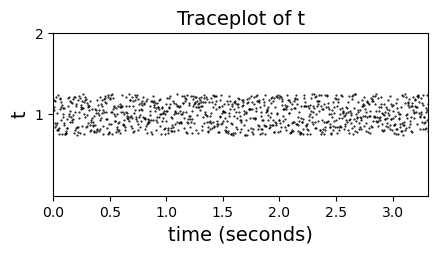

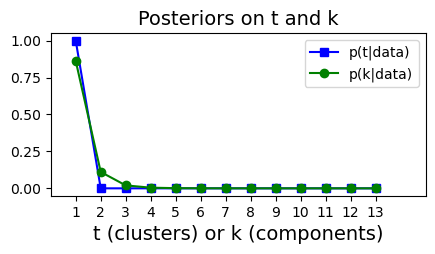

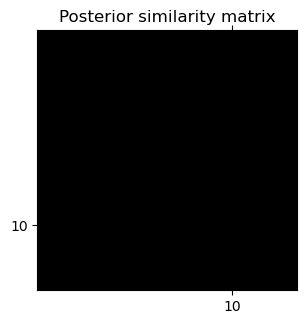


1: 0.863
2: 0.111
3: 0.02
4: 0.00449
5: 0.00119
6: 0.000357
7: 0.000118
8: 4.26e-05
9: 1.64e-05
10: 6.72e-06


In [35]:
# A basic example of using the BayesianMixtures package.
using DelimitedFiles
using Statistics
using Random
using CSV

using BayesianMixtures
B = BayesianMixtures

save_figures = true  # save the figures to file

# Simulate some data

dataset = readdlm("Train_data5k.csv",',')
x = convert(Array{Float64,2}, dataset)
x = [x[:,i]::Array{Float64,1} for i = 1:size(x,2)]

# Normalize to zero mean, unit variance
mu = mean(x)
v = mean([xi.*xi for xi in x]) - mu.*mu  # sample variance
x = [((xi-mu)./sqrt.(v))::Array{Float64,1} for xi in x]

# Specify model, data, and MCMC options
n_total = 1000  # total number of MCMC sweeps to run
options = B.options("MVNaaRJ","MFM",x,n_total; n_keep=1000,t_max=13, k_max= 13)  # MFM model with univariate Normal components
# Run MCMC sampler
result = B.run_sampler(options)



fignum = 0
# Traceplot of t
global fignum
B.open_figure(fignum)
t_show = 60  # number of seconds to show
B.traceplot_timewise(result,t_show)
# B.PyPlot.title("$label, d = $d")
if save_figures; B.PyPlot.savefig("test.png",dpi=200); end

# fignum = 0
# for (i_d,d) in enumerate(ds)
#     B.open_figure(9+i_d)
#     for (label,mode,color) in [("Collapsed Jain-Neal","MVNaaC","g"),
#                                ("Uncollapsed Jain-Neal","MVNaaN","r"),
#                                ("RJMCMC","MVNaaRJ","b")]
    
#         if reset_random; Random.seed!(0); end

#         # Generate data
#         n = 100
#         xs = [randn(d) for i = 1:n]
#         zs = [Int(ceil(rand()*3)) for i = 1:n]
#         shift = (3/sqrt(d))*[-1,0,1]
#         x = convert(Array{Array{Float64,1},1},[xs[i].+shift[zs[i]] for i = 1:n])
#         mu = mean(x)  # sample mean
#         v = mean([xi.*xi for xi in x]) - mu.*mu  # sample variance
#         x = [((xi-mu)./sqrt.(v))::Array{Float64,1} for xi in x] # normalized to zero mean, unit variance

#         # Run sampler
#         println(label)
#         options = B.options(mode,"MFM",x,n_total; n_keep=1000,t_max=20)
#         result = B.run_sampler(options)

#         # Traceplot of t
#         global fignum
#         B.open_figure(fignum+=1)
#         t_show = 20  # number of seconds to show
#         B.traceplot_timewise(result,t_show)
#         B.PyPlot.title("$label, d = $d")
#         if save_figures; B.PyPlot.savefig("simCompareJNtoRJ-traceplot-$mode-d=$d.png",dpi=200); end

#         # Plot autocorrelation
#         B.open_figure(9+i_d; clear_figure=false)
#         t_show = 0.025*d  # number of seconds to show
#         B.plot_autocorrelation(result,t_show; color=color,label=label)
#         B.PyPlot.title("Autocorrelation, d = $d")
#     end
#     if i_d==1; B.PyPlot.legend(loc="upper right",fontsize=12); end
#     if save_figures; B.PyPlot.savefig("simCompareJNtoRJ-autocorrelation-d=$d.png",dpi=200); end
# end

# Posteriors on t and k
B.open_figure(1)
B.plot_t_posterior(result; color="b", marker="s", label="p(t|data)")
B.plot_k_posterior(result; color="g", marker="o", label="p(k|data)")
B.labels("Posteriors on t and k","t (clusters) or k (components)","")
B.PyPlot.legend(loc="upper right",numpoints=1)
B.PyPlot.xlim(0,15)

# Posterior similarity matrix (probability that i and j are in same cluster)
B.open_figure(2; figure_size=(5,4))
B.plot_similarity_matrix(result)



# Display the posterior on k (number of components)
using Printf
println("Posterior on k:")
for (k,pk) in enumerate(B.k_posterior(result; upto=10))
    @printf "%d: %.3g\n" k pk
end


In [16]:
x[1]

160-element Array{Float64,1}:
 -0.05598925109558522
  1.4455598112745625
  1.4186046511627908
  0.6582183780869638
 -0.16552117772047378
 -0.6018932206810411
  0.6064496310619689
 -0.6115928396627279
 -0.505641397029869
  0.22639617957360283
 -1.3896166675593022
  0.3198363140439827
 -0.2561082665968475
  ⋮
  1.5158734579197342
  1.9275882159515374
  0.5577221392197332
  0.3689281589980457
  0.9325048082403138
  2.4952103911249264
  1.3740508422516025
 -1.1666666666666665
  1.2094157958139045
  1.7856153694024042
 -0.18831089428867737
  1.4314958357846703

## my part 2

In [60]:
# A basic example of using the BayesianMixtures package.
using DelimitedFiles
using Statistics

using BayesianMixtures
B = BayesianMixtures

# Simulate some data

dataset = readdlm("malaria_cell.csv",',')
x = convert(Array{Float64,2}, dataset[2:end,2:end])
x = [x[:,i]::Array{Float64,1} for i = 1:size(x,2)]



# Normalize to zero mean, unit variance
mu = mean(x)
v = mean([xi.*xi for xi in x]) - mu.*mu  # sample variance
x = [((xi-mu)./sqrt.(v))::Array{Float64,1} for xi in x]


# Run sampler
n_total = 1000  # number of MCMC sweeps to run the algorithm
options = B.options("MVNaaRJ","MFM",x,n_total; n_keep=1000,t_max=5)
result = B.run_sampler(options)


# Posteriors on t and k
B.open_figure(1)
B.plot_t_posterior(result; color="b", marker="s", label="p(t|data)")
B.plot_k_posterior(result; color="g", marker="o", label="p(k|data)")
B.labels("Posteriors on t and k","t (clusters) or k (components)","")
B.PyPlot.legend(loc="upper right",numpoints=1)
B.PyPlot.xlim(0,15)

# Posterior similarity matrix (probability that i and j are in same cluster)
B.open_figure(2; figure_size=(5,4))
B.plot_similarity_matrix(result)


end

MVNaaRJ MFM
n = 9, n_total = 1000, n_keep = 1000
Running... 

LoadError: AssertionError: list capacity exceeded

In [53]:
# Generate data
n = 100
d=4
xs = [randn(d) for i = 1:n]
zs = [Int(ceil(rand()*3)) for i = 1:n]
shift = (3/sqrt(d))*[-1,0,1]
x = convert(Array{Array{Float64,1},1},[xs[i].+shift[zs[i]] for i = 1:n])
mu = mean(x)  # sample mean
v = mean([xi.*xi for xi in x]) - mu.*mu  # sample variance
x = [((xi-mu)./sqrt.(v))::Array{Float64,1} for xi in x] # normalized to zero mean, unit variance

# Run sampler
n_total = 1000  # number of MCMC sweeps to run the algorithm
options = B.options("MVNaaRJ","MFM",x,n_total; n_keep=1000,t_max=5)
result = B.run_sampler(options)


# Posteriors on t and k
B.open_figure(1)
B.plot_t_posterior(result; color="b", marker="s", label="p(t|data)")
B.plot_k_posterior(result; color="g", marker="o", label="p(k|data)")
B.labels("Posteriors on t and k","t (clusters) or k (components)","")
B.PyPlot.legend(loc="upper right",numpoints=1)
B.PyPlot.xlim(0,15)

# Posterior similarity matrix (probability that i and j are in same cluster)
B.open_figure(2; figure_size=(5,4))
B.plot_similarity_matrix(result)


end

MVNaaRJ MFM
n = 100, n_total = 1000, n_keep = 1000
Running... 

LoadError: AssertionError: list capacity exceeded

Collapsed Jain-Neal
MVNaaC MFM
n = 10, n_total = 10, n_keep = 10
Running... complete.
Elapsed time = 0.000278 seconds
Time per step ~ 2.7799999999999996e-6 seconds


Uncollapsed Jain-Neal
MVNaaN MFM
n = 10, n_total = 10, n_keep = 10
Running... complete.
Elapsed time = 0.0003091 seconds
Time per step ~ 3.0909999999999997e-6 seconds

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


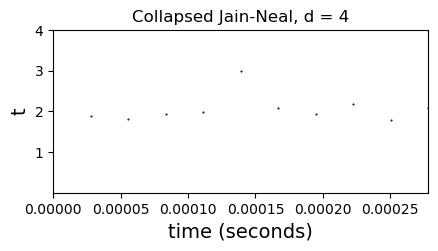

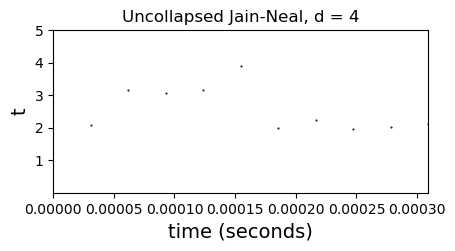

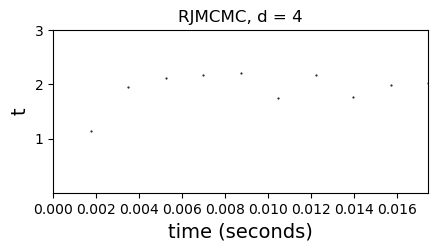

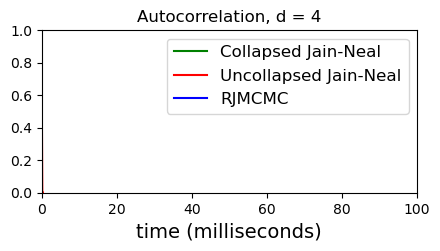


RJMCMC
MVNaaRJ MFM
n = 10, n_total = 10, n_keep = 10
Running... complete.
Elapsed time = 0.0174294 seconds
Time per step ~ 0.00017429400000000002 seconds


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


Main.SimCompareJNtoRJ

In [139]:
# Compare Jain-Neal sampler to Reversible Jump on simulated data of increasing dimension.
module SimCompareJNtoRJ

using Statistics
using Random
using BayesianMixtures
B = BayesianMixtures

# Settings
ds = [4]  # increasing dimensions
reset_random = true  # reset the random number generator before each run
save_figures = true  # save the figures to file
n_total = 10  # number of MCMC sweeps to run each algorithm

fignum = 0
for (i_d,d) in enumerate(ds)
    B.open_figure(9+i_d)
    for (label,mode,color) in [("Collapsed Jain-Neal","MVNaaC","g"),
                               ("Uncollapsed Jain-Neal","MVNaaN","r"),
                               ("RJMCMC","MVNaaRJ","b")]
    
        if reset_random; Random.seed!(0); end

        # Generate data
        n = 10
        xs = [randn(d) for i = 1:n]
        zs = [Int(ceil(rand()*3)) for i = 1:n]
        shift = (3/sqrt(d))*[-1,0,1]
        x = convert(Array{Array{Float64,1},1},[xs[i].+shift[zs[i]] for i = 1:n])
        mu = mean(x)  # sample mean
        v = mean([xi.*xi for xi in x]) - mu.*mu  # sample variance
        x = [((xi-mu)./sqrt.(v))::Array{Float64,1} for xi in x] # normalized to zero mean, unit variance

        # Run sampler
        println(label)
        options = B.options(mode,"MFM",x,n_total; n_keep=1000,t_max=20)
        result = B.run_sampler(options)

        # Traceplot of t
        global fignum
        B.open_figure(fignum+=1)
        t_show = 20  # number of seconds to show
        B.traceplot_timewise(result,t_show)
        B.PyPlot.title("$label, d = $d")
        if save_figures; B.PyPlot.savefig("simCompareJNtoRJ-traceplot-$mode-d=$d.png",dpi=200); end

        # Plot autocorrelation
        B.open_figure(9+i_d; clear_figure=false)
        t_show = 0.025*d  # number of seconds to show
        B.plot_autocorrelation(result,t_show; color=color,label=label)
        B.PyPlot.title("Autocorrelation, d = $d")
    end
    if i_d==1; B.PyPlot.legend(loc="upper right",fontsize=12); end
    if save_figures; B.PyPlot.savefig("simCompareJNtoRJ-autocorrelation-d=$d.png",dpi=200); end
end

end # module SimCompareJNtoRJ

In [106]:
# Generate data
d= 8
n = 100
xs = [randn(d) for i = 1:n]
zs = [Int(ceil(rand()*3)) for i = 1:n]
shift = (3/sqrt(d))*[-1,0,1]
x = convert(Array{Array{Float64,1},1},[xs[i].+shift[zs[i]] for i = 1:n])

println(x)

mu = mean(x)  # sample mean
v = mean([xi.*xi for xi in x]) - mu.*mu  # sample variance
x = [((xi-mu)./sqrt.(v))::Array{Float64,1} for xi in x] # normalized to zero mean, unit variance
yy= x
println(yy[1,:])
println(yy)

[[-0.6280650049589176, 1.0714685531004278, 0.6607160722676569, 0.6927003117840081, -0.23688287996355614, 0.1560822525583476, 0.2725096250202943, 0.2735754321940238], [0.20646775540647402, 0.2777890151350102, 0.007650410637442192, -0.3978215839858518, 0.43111634062325715, 0.5699495731479988, -0.7834659697166498, -0.43030457145411805], [-0.11533034117819978, 0.26367509109809484, -2.5114979598974667, 0.09353049857447153, -0.9082545896522926, -0.22179602469222334, 1.0547907150943943, -0.6063145430978207], [-0.634378802001103, -0.08268244633015548, 0.5616109652704029, -0.4439761471438842, -1.9743074135514938, 0.21275455872824667, -1.1475887895437278, 0.9951272782505938], [-0.7138163685200909, -1.4635713179182626, -2.21277571224034, -0.46651905659969917, 0.08474197670871564, -0.5701058408364236, -0.98182236362095, -1.412558563692604], [-1.87614329594363, -2.6843875275612445, -0.3493476400417461, -2.512853956359975, -0.31828078959473505, -1.2621992346680728, -2.493048396699257, -0.28006850910

 -0.28674099348767623], [-0.9648064054336546, 1.249970184863668, -1.2779610444075107, 0.7377556309739319, 0.4618887881683052, 0.801660574066586, 1.324332754420836, -0.6394063124046125], [1.813837009125454, 0.5150512318910211, 2.215420485152328, 2.236545011782497, -0.28109098714228486, 3.6422279759298606, 1.1239241628583834, 1.3828672850766162], [-0.285225307094227, 1.2512198871522355, -0.6272277331614815, 0.2602411893842437, 0.7267541352884104, -0.025241902614610297, -0.016872773652322356, 0.08675877879057244], [-3.81234952409517, -1.2413744759205192, -1.279114000995257, -1.7039645813917135, 0.05226950938891761, 0.40756034457452617, -0.597782325341158, -0.5786746572324202], [-0.5205097099398851, 1.611545897216522, 0.7457688630913365, -0.10013965661633026, 0.021723663062740844, -2.0173407591334525, 3.6657767834080697, -0.6400633044352199], [1.546449861102777, 0.8845463006884692, 0.9277601800950019, 2.131300364209639, 1.498919532771413, 1.8276055950536638, 0.21641711782585427, 2.27917506

In [57]:
x

100-element Array{Array{Float64,1},1}:
 [-0.08186948862034496, -0.22484375517264965, 0.5889633128751233, -0.26431624590083946]
 [-1.1889992497939332, -0.8164246543146307, 0.03435877232088995, -0.053665561753458886]
 [-1.8943705413079714, -1.0544229012044368, -1.4993663551929535, -0.4744805397172821]
 [-2.2233515698490023, -1.033835256025011, -0.1474460928209955, -1.1759681976701881]
 [-0.06599636129589562, 0.7688606690902746, 1.2514808511271198, 1.3752221427743283]
 [0.18376538776669146, 0.9825259425503752, 0.46035895154147416, 1.5058585489740968]
 [0.9683941281614362, 1.1934327467093822, 0.4946515569629738, 2.4702261388922038]
 [0.1591123954732799, -0.6939410657867473, -0.5640042044486285, 0.053442774159820954]
 [0.20409170016764094, 1.2161207565963457, 0.8698082217765072, 0.6018876286222483]
 [-1.2231741569776626, -1.360059641750298, -1.298255284311146, -0.7632611382680392]
 [1.40531249727831, 1.173477103343382, -1.2691248742333705, 0.7226073537096299]
 [1.0053351089706497, 1.1943294

In [48]:
size(x)

(0,)

In [31]:
x[1:5]

5-element Array{Array{Float64,1},1}:
 [1.4195468819753525, -0.5564148840746572, 0.7111512762185723, -0.17474081133220767, -0.64761929035041, -1.4834770727423172, 0.611468564449338, -0.9150793638884737, 0.2393249809829752, 0.2065984676353345  …  -0.8702852691526738, -0.8905881248488706, -1.2927192249875477, -0.9899494936611665, -1.2088531618235643, -1.7639057901043447, -1.2935483472729858, -1.2374368670764582, -1.2728916546811682, -1.3736056394868905]
 [0.1419546881975353, -1.0571882797418486, -0.958508241859815, -0.17474081133220767, 2.266667516226435, -0.41537358036784877, 0.611468564449338, 0.20797258270192573, -0.2222303394841913, -0.0590281336100953  …  2.0669275142376002, -0.5699763999032772, 1.0341753799900382, 0.9192388155425117, 0.6832648305959278, 1.2395013660192695, 1.8408188018884797, 0.3535533905932738, 0.5171122347142246, 1.0988845115895123]
 [1.1001488335308982, -0.05564148840746574, -0.958508241859815, 1.0047596651601935, -1.1774896188189272, 0.6527299120066196, -0.65850

In [97]:
dataset = readdlm("Brain1.csv",',')
x = convert(Array{Float64,2}, dataset[2:end,2:end])
# x = [x[:,i]::Array{Float64,1} for i = 1:size(x,2)]

println(size(x,2))

# Normalize to zero mean, unit variance
mu = mean(x)
v = mean([xi.*xi for xi in x]) - mu.*mu  # sample variance
x = [((xi-mu)./sqrt.(v))::Array{Float64,1} for xi in x]

LoadError: arraysize: dimension out of range